In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from pygcn.utils import load_data, accuracy
from pygcn.models import GCN
from pygcn.train import train, test

In [3]:
# Setting
seed = 42
num_epoch = 201
lr = 0.01
weight_decay = 5e-4
hidden = 16
dropout = 0.5
cuda = False

In [4]:
np.random.seed(seed)
torch.manual_seed(seed)

# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data(path="data/cora/")

# Model and optimizer
model = GCN(nfeat=features.shape[1],
                nhid=hidden,
                nclass=labels.max().item() + 1,
                dropout=dropout)
optimizer = optim.Adam(model.parameters(),
                        lr=lr, weight_decay=weight_decay)


Loading cora dataset...
Done loading cora dataset


In [5]:
# Move to cuda if use GPU
if cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

In [6]:
# Train model
train(features, adj, labels, idx_train, idx_val, model, optimizer, num_epoch)    

Epoch: 0001 loss_train: 1.9211 acc_train: 0.1357 loss_val: 1.9001 acc_val: 0.3500 time: 0.0238s
Epoch: 0021 loss_train: 1.7398 acc_train: 0.2929 loss_val: 1.7308 acc_val: 0.3500 time: 0.0101s
Epoch: 0041 loss_train: 1.5331 acc_train: 0.3929 loss_val: 1.5824 acc_val: 0.3633 time: 0.0102s
Epoch: 0061 loss_train: 1.2154 acc_train: 0.7143 loss_val: 1.3419 acc_val: 0.6500 time: 0.0098s
Epoch: 0081 loss_train: 0.9170 acc_train: 0.8000 loss_val: 1.1101 acc_val: 0.7633 time: 0.0098s
Epoch: 0101 loss_train: 0.7594 acc_train: 0.8286 loss_val: 0.9479 acc_val: 0.7833 time: 0.0098s
Epoch: 0121 loss_train: 0.6273 acc_train: 0.8643 loss_val: 0.8560 acc_val: 0.7900 time: 0.0232s
Epoch: 0141 loss_train: 0.5331 acc_train: 0.8857 loss_val: 0.7993 acc_val: 0.7933 time: 0.0105s
Epoch: 0161 loss_train: 0.4939 acc_train: 0.9071 loss_val: 0.7559 acc_val: 0.8000 time: 0.0098s
Epoch: 0181 loss_train: 0.4434 acc_train: 0.9286 loss_val: 0.7253 acc_val: 0.8000 time: 0.0100s
Epoch: 0201 loss_train: 0.4116 acc_train

In [7]:
# Test model
test(features, adj, labels, idx_test, model)

Test set results: loss= 0.7358 accuracy= 0.8250


In [8]:
# shape of final GCN output
# 2708 nodes, 7 features each
model.eval()
output = model(features, adj)
output = output.cpu().detach().numpy()
#save embeddings in numpy format file
np.save('embedding_1.npy', output)
print(output.shape)

(2708, 7)


In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [10]:
import pandas as pd

In [11]:
feat_cols = [ 'dim'+str(i) for i in range(output.shape[1])]
df = pd.DataFrame(output, columns=feat_cols)
df['label'] = labels
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (2708, 8)


In [12]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.5241648  0.24967457 0.09514949]


In [13]:
print(df[feat_cols].values)

[[-6.057353   -5.542034   -0.06659412 ... -4.251909   -6.9338045
  -5.446407  ]
 [-2.6774957  -3.1383128  -4.2113786  ... -2.5265183  -0.6693437
  -1.3737656 ]
 [-4.3893003  -3.7300353  -2.9764512  ... -0.17180014 -3.7100472
  -3.1368957 ]
 ...
 [-3.0192542  -0.36855483 -3.016877   ... -2.8625147  -2.527467
  -2.9678783 ]
 [-0.36607504 -3.4664016  -3.4454703  ... -3.3578477  -2.5439308
  -2.4777148 ]
 [-4.3439965  -4.039097   -0.1330688  ... -3.8097656  -5.424506
  -4.72402   ]]


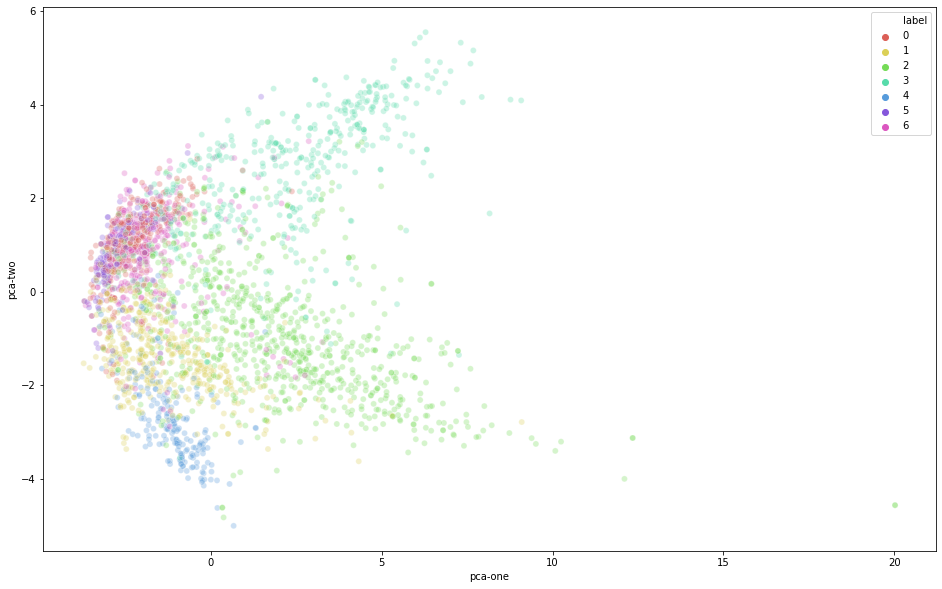

In [14]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", 7),
    data=df.loc[:,:],
    legend="full",
    alpha=0.3
)

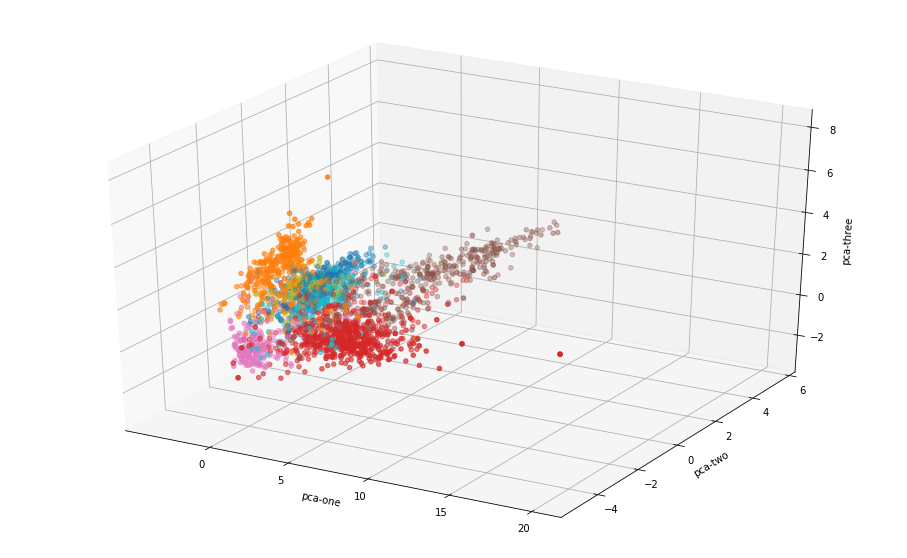

In [15]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[:,:]["pca-one"], 
    ys=df.loc[:,:]["pca-two"], 
    zs=df.loc[:,:]["pca-three"], 
    c=df.loc[:,:]["label"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [17]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=10000)
tsne_results = tsne.fit_transform(df[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.004s...
[t-SNE] Computed neighbors for 2708 samples in 0.121s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.554853
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.793209
[t-SNE] KL divergence after 8950 iterations: 0.715280
t-SNE done! Time elapsed: 151.13069939613342 seconds


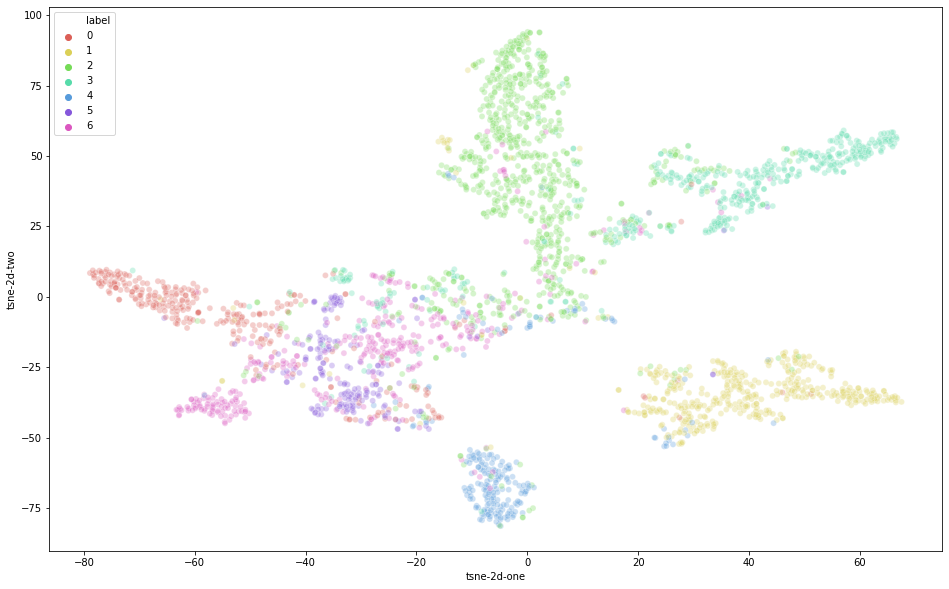

In [18]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 7),
    data=df,
    legend="full",
    alpha=0.3
)

In [ ]:
# After you train the model, you can try to export the embeddings into the file (numpy)
# You can train and generate the embeddings with another seed
# You can try to calculate the alignment matrix by using the dot product
# You can try to visualize the two embedding spaces